# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**План работы**
1. Предобработка данных (обработка пропущенных значений, аномалий, явных и неявных дубликатов)
2. Создание новых столбцов для дальнейшего анализа
3. Исследование данных с исмпользованием графиков и срезов
4. Отсекание аномалий для дальнейшего анализа
5. Исследование и выявление зависимостей различных метрик выборки

### Откройте файл с данными и изучите общую информацию

In [1]:
import numpy as np 
import pandas as pd
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [2]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

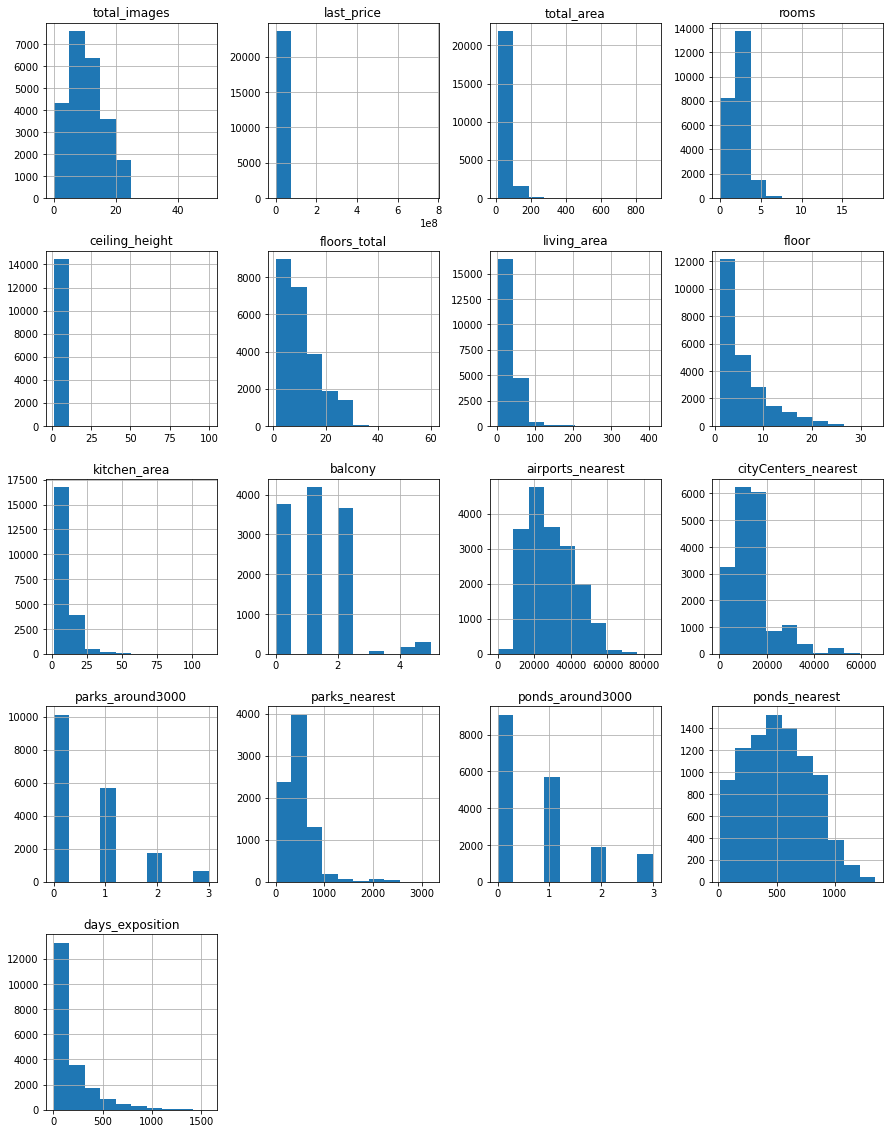

In [3]:
data.hist(figsize=(15,20))

### Выполните предобработку данных

In [4]:
data.isna().sum() #найдем нулевые занчения по всем столбцам

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Обработка пропущенных значений в столбцах

In [5]:
#т.к. количество пустых значений в столбцах <1% от общего числа строк, удалим строки с пустыми значениями в этих столбцах
data=data.dropna(subset=['floors_total','locality_name']) 

Обработка пропусков в столбце ceiling_height

In [6]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [7]:
# видно что есть не только нулевые значения высоты потолка но и аномальные 
# примем что это опечатки в запятой и значения более 11 метров уменьшим в 10 раз для дальнейшей обработки
data.loc[data['ceiling_height']>11 , 'ceiling_height'] = data['ceiling_height']*0.1

In [8]:
#высота потолка в квартире зависит в том числе от этажности здания, буду заполнять высоту потолков медианным значением по этажности зданий
data.groupby('floors_total')['ceiling_height'].agg('median')

floors_total
1.0     2.80
2.0     2.70
3.0     2.80
4.0     3.00
5.0     2.55
6.0     3.00
7.0     3.00
8.0     2.80
9.0     2.55
10.0    2.60
11.0    2.75
12.0    2.65
13.0    2.70
14.0    2.60
15.0    2.70
16.0    2.70
17.0    2.70
18.0    2.70
19.0    2.75
20.0    2.75
21.0    2.70
22.0    2.75
23.0    2.75
24.0    2.75
25.0    2.75
26.0    2.66
27.0    2.70
28.0    2.60
29.0    2.60
33.0     NaN
34.0    2.65
35.0    2.70
36.0    2.70
37.0    1.75
52.0    2.65
60.0    2.88
Name: ceiling_height, dtype: float64

In [9]:
#высота потолка в квартире зависит в том числе от этажности здания, буду заполнять высоту потолков медианным значением по этажности зданий
data.loc[data['floors_total'] == 33, 'ceiling_height'] = data['ceiling_height'].median() # закроем аномалию для 33 этажного здания общей медианой 
#заменим пустые значения медианами по этажности зданий
for t in data['floors_total'].unique():
    data.loc[(data['floors_total'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = data.loc[
            (data['floors_total'] == t), 'ceiling_height'].median()
  
        

In [10]:
#предполагаю что стобец is_apartment не заполнен для тех квартир, которые не являются аппартаментами, поэтому заполню пропуски значение False
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

# если не указано число балконов, то скорее всего их нет, заменим пустые значения на 0 и сменим тип столбца на целочисленный
data.loc[data['balcony'].isna(), 'balcony'] = 0


Обработка пропустков в столбцах living_area и kitchen_area

In [11]:
data['living_area'].corr(data['total_area'])

0.9397711143610334

In [12]:
data['kitchen_area'].corr(data['total_area'])

0.6092476784548312

    Площадь кухни и жилая площадь зависят от общей площади квартиры, т.к. в выборке нет данных о санузлах и нежилых помещениях, то посчитаем отношение средней жилой площади к средней общей площади и заполним пустые значения умножив жилую площадь на полученный коэффициент. Тоже самое проделаем с площадью кухни.


In [13]:
Living_k = data['living_area'].mean()/data['total_area'].mean()
kitchen_k = data['kitchen_area'].mean()/data['total_area'].mean()

data.loc[data['living_area'].isna(), 'living_area'] = data['total_area']*Living_k
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area']*kitchen_k



In [14]:
#пропуски в столбце days_exposition заполняем медианным значением по всей выборке
#data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].median()       

In [15]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')
data['year_exposition'] = data['first_day_exposition'].dt.year
data_exposition = data.loc[data['days_exposition'].isna()] 
data_exposition.pivot_table(index='year_exposition', values='first_day_exposition', aggfunc='count')

,first_day_exposition
year_exposition,
2014,18
2015,70
2016,67
2017,271
2018,957
2019,1788



    При анализе данных в столбце days_exposition по годам, стало ясно что большая часть пропущенных значений в этом столбце с датой публикации в 2019 году, т.е. вероятнее всего это еще не проданные квартиры. В таком случае пропуски не следует считать случайными, попробуем проводить анализ оставив этот столбец как есть


In [16]:
data.isna().sum() #проверим нулевые значения по всем столбцам

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
year_exposition             0
dtype: int64

    Были обработаны пустые значения в столбцах, которые по условию задачи заполняются пользователем, таким образом можно считать что большая часть пропущенных данных образовалась из-за человеческого фактора (не указан признак в виду его отсутсвия, не заполнено количество балконов если их нет, пропущены по ошибке данные и тд).
    Остальные столбцы с нулевыми значениями по условиям задачи получены на основе картографических данных и они заполняются без участия пользователей, поэтому оставим их как есть. Предположу, что могла быть какая-либо техническая ошибка. Так же отмечу, что для столбца с количеством парков parks_around3000  в радиусе 3км = 0 значение в стобце parks_nearest = NaN, такая же ситуация для столбцов с водоемами.

#### Изменение типов данных в столбцах

In [17]:
# изменим типы данных в некоторых столбцах для удобства работы с ними
data['floors_total'] = data['floors_total'].astype(int) 
data['is_apartment'] = data['is_apartment'].astype(bool)
data['balcony'] = data['balcony'].astype(int)
#data['days_exposition'] = data['days_exposition'].astype(int)

In [18]:
# столбец с датой размещения объявления приведем к соответствующему формату
#data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

Изменение типов данных в столбцах необходимо для удобства при анализе данных, при построении графиков и вывода результатов. Также от типа данных зависит скорость работы кода и используемая память

#### Устранение неявных дубликатов в столбце locality_name


In [20]:
#сначала приведем все названия к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower()
sorted(data['locality_name'].unique())

['бокситогорск',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'высоцк',
 'гатчина',
 'городской поселок большая ижора',
 'городской поселок янино-1',
 'городской посёлок будогощь',
 'городской посёлок виллози',
 'городской посёлок лесогорский',
 'городской посёлок мга',
 'городской посёлок назия',
 'городской посёлок новоселье',
 'городской посёлок павлово',
 'городской посёлок рощино',
 'городской посёлок свирьстрой',
 'городской посёлок советский',
 'городской посёлок фёдоровское',
 'городской посёлок янино-1',
 'деревня агалатово',
 'деревня аро',
 'деревня батово',
 'деревня бегуницы',
 'деревня белогорка',
 'деревня большая вруда',
 'деревня большая пустомержа',
 'деревня большие колпаны',
 'деревня большое рейзино',
 'деревня большой сабск',
 'деревня бор',
 'деревня борисова грива',
 'деревня ваганово',
 'деревня вартемяги',
 'деревня вахнова кара',
 'деревня выскатка',
 'деревня гарболово',
 'деревня глинка',
 'деревня горбунки',
 'деревня гостилицы',
 'деревня заклинье',

In [21]:
data['locality_name'].nunique()

364

In [22]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е').str.replace(
    'городской поселок', 'поселок городского типа').str.replace('при железнодорожной станции', 'станции').replace(
    'мурино','поселок мурино').replace('поселок рябово','поселок городского типа рябово').replace(
    'любань','поселок любань')

sorted(data['locality_name'].unique())

['бокситогорск',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'высоцк',
 'гатчина',
 'деревня агалатово',
 'деревня аро',
 'деревня батово',
 'деревня бегуницы',
 'деревня белогорка',
 'деревня большая вруда',
 'деревня большая пустомержа',
 'деревня большие колпаны',
 'деревня большое рейзино',
 'деревня большой сабск',
 'деревня бор',
 'деревня борисова грива',
 'деревня ваганово',
 'деревня вартемяги',
 'деревня вахнова кара',
 'деревня выскатка',
 'деревня гарболово',
 'деревня глинка',
 'деревня горбунки',
 'деревня гостилицы',
 'деревня заклинье',
 'деревня заневка',
 'деревня зимитицы',
 'деревня извара',
 'деревня иссад',
 'деревня калитино',
 'деревня кальтино',
 'деревня камышовка',
 'деревня каськово',
 'деревня келози',
 'деревня кипень',
 'деревня кисельня',
 'деревня колтуши',
 'деревня коркино',
 'деревня котлы',
 'деревня кривко',
 'деревня кудрово',
 'деревня кузьмолово',
 'деревня курковицы',
 'деревня куровицы',
 'деревня куттузи',
 'деревня лаврики',
 'деревня

In [23]:
data['locality_name'].nunique()

318

### Добавьте в таблицу новые столбцы

In [24]:
data['one_meter_price'] = (data['last_price']/data['total_area']).round(2) # создадим столбец с ценой одного квадратного метра

data['weekday_exposition'] = data['first_day_exposition'].dt.weekday #создадим столбец с номером дня недели публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month # столбец с месяцем публикации объявления
#data['year_exposition'] = data['first_day_exposition'].dt.year #столбец с годом публикации обьявления

# добавим столбец с типом этажа, для этого создадим функцию, кот будет проверять номер этажа
def floor_type(row): 
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1) 

data = data.rename(columns={'cityCenters_nearest':'citycenters_nearest'}) # приведем название столбца к нижнему регистру
data['citycenters_nearest_km'] = (data['citycenters_nearest']/1000).round(0) # создадим столбец с расстоянием до центра в км

data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year_exposition,one_meter_price,weekday_exposition,month_exposition,floor_type,citycenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2.0,755.0,NaN,2019,120370.37,3,3,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.75,11,18.600000,1,False,...,NaN,0.0,NaN,81.0,2018,82920.79,1,12,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.55,5,34.300000,4,False,...,90.0,2.0,574.0,558.0,2015,92785.71,3,8,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.60,14,90.816648,9,False,...,84.0,3.0,234.0,424.0,2015,408176.10,4,7,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1.0,48.0,121.0,2018,100000.00,1,6,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,NaN,NaN,NaN,55.0,2018,95065.79,0,9,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.66,26,10.600000,6,False,...,NaN,0.0,NaN,155.0,2017,99195.71,3,11,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.75,24,40.896050,22,False,...,NaN,0.0,NaN,NaN,2019,110544.69,3,4,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.70,27,15.430000,26,False,...,NaN,NaN,NaN,189.0,2018,87454.76,2,5,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,NaN,0.0,NaN,289.0,2017,88524.59,6,2,другой,15.0


### Проведите исследовательский анализ данных

#### Изучение параметры объектов

In [25]:
data_rows = data.shape[0]
data_rows

23565

##### Изучим данные об общей площади, жилой площади и площади кухни, будем строить гистограммы и отсекать данные слишком выбивающиеся из выборки

In [26]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

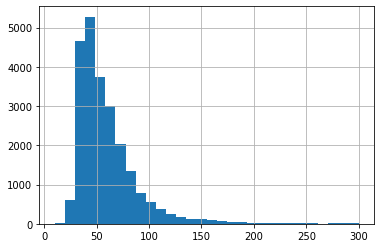

In [27]:
data['total_area'].hist(bins=30, range=(10,300))

In [28]:
#отсечем 1% от крайних значений, т.к. они явно выбиваются из выборки
data = data.loc[(data['total_area']<np.percentile(data['total_area'], 99))&(
    data['total_area']>np.percentile(data['total_area'], 1))] 

In [29]:
data['living_area'].describe()

count    23093.000000
mean        33.450438
std         17.194180
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

In [30]:
data['living_area'].value_counts()

18.000000     861
17.000000     659
30.000000     598
20.000000     473
16.000000     465
             ... 
40.390000       1
19.488453       1
164.700000      1
59.173614       1
16.740000       1
Name: living_area, Length: 2225, dtype: int64

<AxesSubplot:>

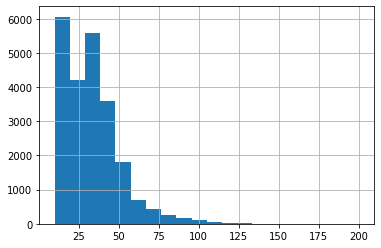

In [31]:
data['living_area'].hist(bins=20, range=(10,200))

In [32]:
#отсечем 1% от крайних значений, т.к. они явно выбиваются из выборки
#data = data.loc[(data['living_area']<np.percentile(data['living_area'], 99))&(
    #data['living_area']>np.percentile(data['living_area'], 1))] 

In [33]:
#т.к. на гистограмме есть выбросы, проверим нет ли аномальных данных, когда жилая площадь больше общей или меньше кухни
data.loc[data['total_area']<data['living_area']] 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year_exposition,one_meter_price,weekday_exposition,month_exposition,floor_type,citycenters_nearest_km


In [34]:
data.loc[data['living_area']<data['kitchen_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year_exposition,one_meter_price,weekday_exposition,month_exposition,floor_type,citycenters_nearest_km
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.0,1.0,48.0,121.0,2018,100000.00,1,6,другой,8.0
6,6,3700000.0,37.30,2017-11-02,1,2.66,26,10.60,6,False,...,NaN,0.0,NaN,155.0,2017,99195.71,3,11,другой,19.0
51,7,45000000.0,161.00,2017-10-17,3,3.20,8,38.00,4,False,...,NaN,3.0,99.0,541.0,2017,279503.11,1,10,другой,7.0
53,7,4300000.0,39.10,2017-11-10,1,2.75,25,15.40,13,False,...,NaN,0.0,NaN,6.0,2017,109974.42,4,11,другой,19.0
101,4,3000000.0,37.00,2019-03-23,1,2.75,10,12.00,3,False,...,NaN,NaN,NaN,NaN,2019,81081.08,5,3,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23208,12,4800000.0,37.00,2016-02-24,1,2.60,14,8.00,11,False,...,358.0,1.0,950.0,139.0,2016,129729.73,2,2,другой,12.0
23388,7,5400000.0,43.00,2017-04-24,1,2.70,18,12.00,8,False,...,NaN,0.0,NaN,124.0,2017,125581.40,0,4,другой,16.0
23481,1,3000000.0,37.29,2019-04-15,1,2.75,19,10.08,10,False,...,NaN,0.0,NaN,7.0,2019,80450.52,0,4,другой,15.0
23573,8,6290000.0,47.67,2019-03-20,1,3.60,12,13.59,12,False,...,253.0,2.0,99.0,19.0,2019,131948.81,2,3,последний,16.0


In [35]:
#удалим строки в которых площадь кухни сильно превышает жилую площадь, как аномальные
data = data.loc[data['living_area']>data['kitchen_area']] 

In [36]:
data.loc[(data['living_area']+data['kitchen_area'])>data['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year_exposition,one_meter_price,weekday_exposition,month_exposition,floor_type,citycenters_nearest_km
184,7,2600000.0,30.20,2018-02-14,1,2.65,9,26.10,5,False,...,NaN,1.0,824.0,12.0,2018,86092.72,2,2,другой,15.0
424,14,11500000.0,98.00,2016-05-10,3,2.65,3,88.00,3,False,...,NaN,0.0,NaN,90.0,2016,117346.94,1,5,последний,13.0
440,8,2480000.0,27.11,2018-03-12,0,2.70,17,24.75,4,False,...,NaN,2.0,982.0,64.0,2018,91479.16,0,3,другой,15.0
551,8,3100000.0,31.59,2018-03-08,1,2.70,19,30.55,2,False,...,NaN,NaN,NaN,70.0,2018,98132.32,3,3,другой,NaN
601,12,5600000.0,53.70,2017-04-18,2,2.50,12,48.30,5,False,...,220.0,1.0,1250.0,167.0,2017,104283.05,1,4,другой,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21956,0,5200000.0,46.00,2018-07-20,2,2.55,5,44.00,5,False,...,488.0,0.0,NaN,7.0,2018,113043.48,4,7,последний,15.0
22095,6,2194000.0,36.50,2017-09-27,1,2.80,3,33.20,3,False,...,NaN,2.0,639.0,36.0,2017,60109.59,2,9,последний,18.0
22246,6,3100000.0,27.30,2018-05-29,0,2.70,16,23.30,15,False,...,NaN,0.0,NaN,59.0,2018,113553.11,1,5,другой,10.0
23102,0,5800000.0,66.00,2017-06-09,5,2.55,5,55.50,1,False,...,NaN,0.0,NaN,21.0,2017,87878.79,4,6,первый,12.0


In [37]:
#удалим строки в которых суммарно площадь кухни и жилая сильно превышает общую площадь, как аномальные
data = data.loc[(data['living_area']+data['kitchen_area'])<data['total_area']] 

<AxesSubplot:>

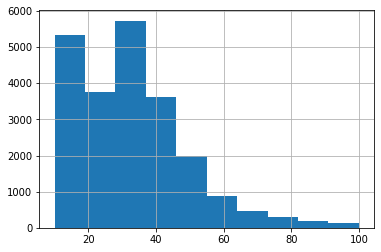

In [38]:
data['living_area'].hist(bins=10, range=(10,100))

In [39]:
data['kitchen_area'].describe()

count    22546.000000
mean        10.051267
std          4.635050
min          1.300000
25%          7.000000
50%          9.000000
75%         11.500000
max         77.000000
Name: kitchen_area, dtype: float64

In [40]:
data['kitchen_area'].sort_values(ascending=True).head(10)

20217    1.30
16367    2.00
906      2.00
11033    2.00
17834    2.30
7950     2.89
15014    3.00
17424    3.00
13814    3.00
3078     3.20
Name: kitchen_area, dtype: float64

<AxesSubplot:>

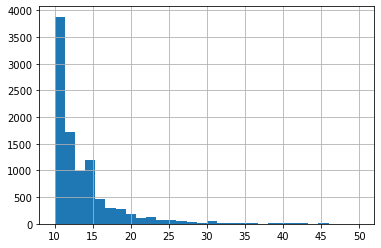

In [41]:
data['kitchen_area'].hist(bins=30, range=(10,50))

In [42]:
#отсечем 1% от крайних значений, т.к. они явно выбиваются из выборки
#data = data.loc[(data['kitchen_area']<np.percentile(data['kitchen_area'], 99))&(
    #data['kitchen_area']>np.percentile(data['kitchen_area'], 1))] 

##### Изучим данные о цене недвижимости будем строить гистограммы и отсекать данные слишком выбивающиеся из выборки

In [43]:
data['last_price'].describe()

count    2.254600e+04
mean     5.987714e+06
std      6.055735e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.688750e+06
max      3.300000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

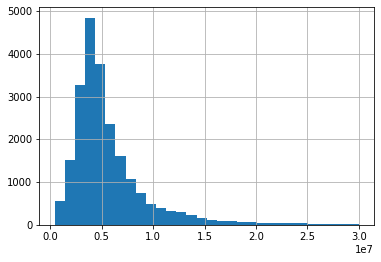

In [44]:
data['last_price'].hist(bins=30, range=(4.300000e+05, 3.000000e+07))

In [45]:
#отсечем 1% от крайних значений, т.к. они явно выбиваются из выборки
data = data.loc[(data['last_price']<np.percentile(data['last_price'], 99))&(
    data['last_price']>np.percentile(data['last_price'], 1))] 

##### Изучим данные о количестве комнат, этаже, высоте потолка будем строить гистограммы и отсекать данные слишком выбивающиеся из выборки

In [46]:
data['rooms'].describe()

count    22084.000000
mean         2.047817
std          0.978913
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

In [47]:
data['rooms'].value_counts()

2     7616
1     7435
3     5559
4     1062
5      231
0      106
6       54
7       18
8        2
11       1
Name: rooms, dtype: int64

In [48]:
data = data.loc[data['rooms']<8] #оставим квартиры с комнатами меньше 8

In [49]:
data.loc[:, 'last_price':'locality_name'].loc[data['rooms']==0]

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
144,2450000.0,27.0,2017-03-30,0,2.75,24,15.500000,2,False,True,False,4.727014,2,поселок мурино
508,3375000.0,34.4,2017-03-28,0,2.66,26,24.300000,19,False,False,True,6.022566,1,поселок парголово
780,2600000.0,26.1,2018-02-20,0,2.70,18,14.907638,8,False,False,True,4.569447,1,поселок мурино
839,1900000.0,35.0,2017-04-14,0,2.70,5,15.000000,3,False,False,True,6.127611,1,поселок новый свет
1173,3240000.0,29.0,2018-10-30,0,2.75,24,17.000000,2,False,True,False,5.077163,2,санкт-петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,3200000.0,26.0,2017-09-01,0,2.75,25,18.000000,16,False,True,False,4.551940,0,санкт-петербург
23442,2500000.0,27.7,2017-09-28,0,2.75,24,18.000000,4,False,False,True,4.849566,2,поселок мурино
23554,3350000.0,26.0,2018-09-07,0,2.75,19,14.850521,8,False,True,False,4.551940,0,санкт-петербург
23592,1450000.0,29.0,2017-11-11,0,2.55,9,18.000000,8,False,False,True,5.077163,2,никольское


In [50]:
# ориентируясь на площадь недвижимости, условно примем что там где стоит количество комнат 0, это однокомнатные квартиры
# т.к. скорее всего 0 комнат стоит у студий либо у квартир с открытой планировкой

data['rooms'].loc[data['rooms']==0] = 1 

<AxesSubplot:>

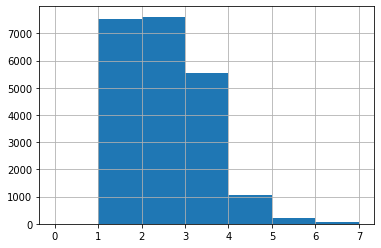

In [51]:
data['rooms'].hist(bins=7, range=(0, 7))

In [52]:
data['ceiling_height'].describe()

count    22081.000000
mean         2.698603
std          0.236330
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max         10.300000
Name: ceiling_height, dtype: float64

In [53]:
#отсечем квартиры с потолками ниже 2м и выше 5 как аномальные значения
data = data.loc[(data['ceiling_height']<5)&(data['ceiling_height']>2)] 

<AxesSubplot:>

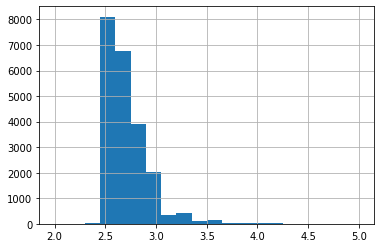

In [54]:
data['ceiling_height'].hist(bins=20, range=(2, 5))

<AxesSubplot:>

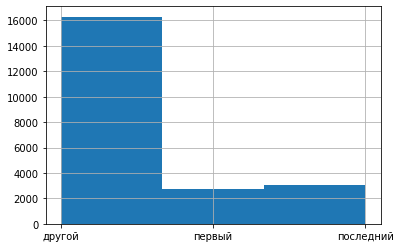

In [55]:
data['floor_type'].hist(bins=3)

In [56]:
data['floors_total'].describe()

count    22059.000000
mean        10.711229
std          6.560419
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

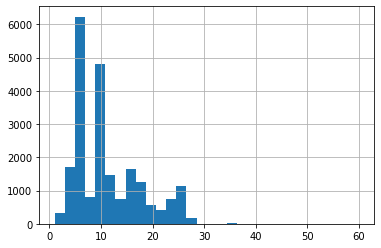

In [57]:
data['floors_total'].hist(bins=30)

##### Изучим данные о расстоянии до центра и ближайшего парка

In [58]:
data['citycenters_nearest'].describe()

count    17055.000000
mean     14465.629493
std       8614.937797
min        208.000000
25%       9766.500000
50%      13242.000000
75%      16424.500000
max      65968.000000
Name: citycenters_nearest, dtype: float64

<AxesSubplot:>

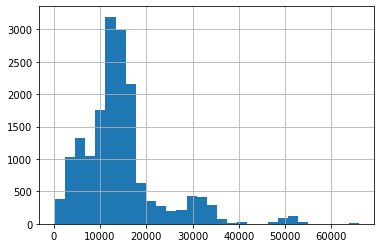

In [59]:
data['citycenters_nearest'].hist(bins=30)

In [60]:
data['parks_nearest'].describe()

count    7450.000000
mean      493.922282
std       340.537595
min         1.000000
25%       292.000000
50%       456.000000
75%       615.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:>

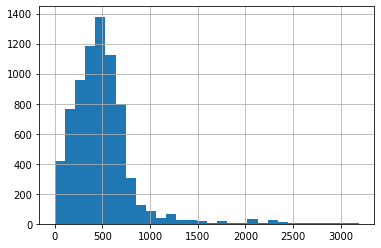

In [61]:
data['parks_nearest'].hist(bins=30)

In [62]:
#после отсечения всех выбросов и аномалий проверим сколько данных из выборки сохранилось
data_rows_after = data.shape[0]
data_rows_after/data_rows

0.9360916613621897

    Для площадей квартир обработали выбросы, убрали по 1% с крайних значений по столбцам выборки, т.к. туда вошли самые редко встречающиеся и аномальные значения. А так же удалили нелогичные данные, где кухня больше жилой площади или сумма площади кухни и жилой больше общей. 
    Для цены объекта недвижимости так же убрали по 1% данных от краев выборки, т.к. они выбивались.
    Оставили данные с высотой потолков от 2 до 5 м, количество комнат до 7, для квартир свободной планировки и студий, где количество комнат было проставлено как 0, поменяла на 1 комнату.
    Для типа этажей выяснили, что меньше всего квартир на первом этаже дома, а больше всего на других этажах. Больше всего продается квартир в 5 и 9 этажках.
    Для расстояния до центра города и до ближайшего парка получили почти нормальное распределение, оставили как есть (учитывая что данные по этим параметрам заполнены не для все выборки).


#### Как быстро продавались квартиры


In [63]:
data['days_exposition'].describe()

count    19154.000000
mean       179.567244
std        218.148352
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [64]:
data['days_exposition'].value_counts()

45.0      811
60.0      521
7.0       217
30.0      197
90.0      176
         ... 
773.0       1
1030.0      1
985.0       1
1452.0      1
1174.0      1
Name: days_exposition, Length: 1123, dtype: int64

In [65]:
#отсечем 1% от максимального значения, т.к. они явно выбиваются из выборки
#data = data.loc[data['days_exposition']<np.percentile(data['days_exposition'], 99)] 

<AxesSubplot:>

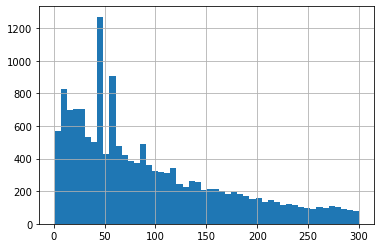

In [81]:
data['days_exposition'].hist(bins=50, range=(1,300))

Максимальное количество осуществлялось на 45 и 60 день публикации, предполагаю это какие то контрольные точки для сервиса, где размещены объявления. (Как для авито, например, через 30 дней предлагают либо закрыть обьявление, либо продлить).
Судя по графику продажу до двух месяцев можно считать быстрой, больше года это уже долгая продажа. 

#### Определение факторов, влияющих на общую стоимость объекта

In [68]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'year_exposition',
       'one_meter_price', 'weekday_exposition', 'month_exposition',
       'floor_type', 'citycenters_nearest_km'],
      dtype='object')

In [69]:
data_corr = data.drop(['total_images', 'first_day_exposition',
       'ceiling_height', 'floors_total', 'floor',
       'is_apartment', 'studio', 'open_plan', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'one_meter_price',
       'citycenters_nearest_km'], axis=1)
data_corr.corr() # построим матрицу корреляции


,last_price,total_area,rooms,living_area,kitchen_area,year_exposition,weekday_exposition,month_exposition
last_price,1.000000,0.786500,0.502999,0.692493,0.635638,-0.025795,-0.013844,0.005116
total_area,0.786500,1.000000,0.796082,0.937046,0.629011,-0.073886,-0.012239,0.006823
rooms,0.502999,0.796082,1.000000,0.874704,0.265919,-0.042116,-0.003020,-0.004314
living_area,0.692493,0.937046,0.874704,1.000000,0.425972,-0.062744,-0.009152,-0.002213
kitchen_area,0.635638,0.629011,0.265919,0.425972,1.000000,-0.052839,-0.007409,0.015338
year_exposition,-0.025795,-0.073886,-0.042116,-0.062744,-0.052839,1.000000,0.000213,-0.273407
weekday_exposition,-0.013844,-0.012239,-0.003020,-0.009152,-0.007409,0.000213,1.000000,0.010473
month_exposition,0.005116,0.006823,-0.004314,-0.002213,0.015338,-0.273407,0.010473,1.000000


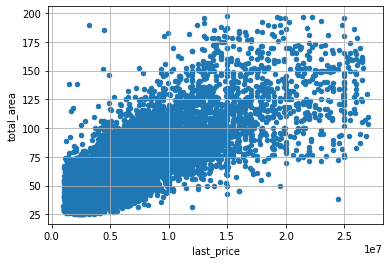

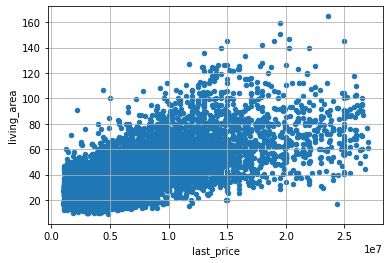

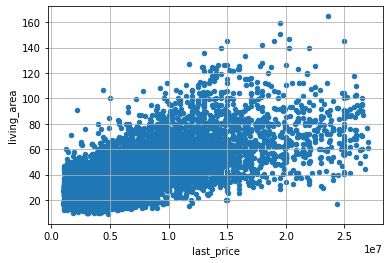

In [70]:
# наибольший коэффициент корреляции между ценой, общей площадью квартиры, жилой площадьи и кухней, что вполне логично и ожидаемо
import matplotlib.pyplot as plt
data.plot(y='total_area', x='last_price', kind='scatter', grid=True)
plt.show()
data.plot(y='living_area', x='last_price', kind='scatter', grid=True)
plt.show()
data.plot(y='living_area', x='last_price', kind='scatter', grid=True)
plt.show()

<AxesSubplot:xlabel='rooms'>

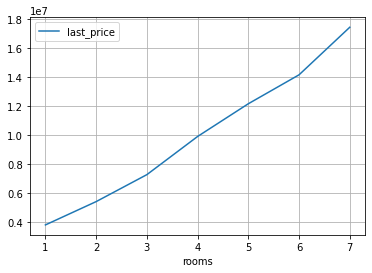

In [71]:
data.pivot_table(index='rooms', values='last_price').plot(grid=True) # зависимость между ценой и количеством комнат

<AxesSubplot:xlabel='floor_type'>

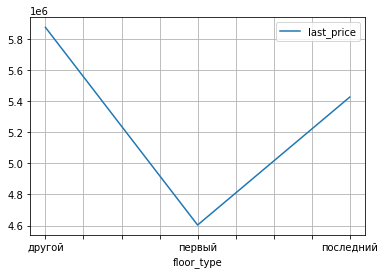

In [72]:
data.pivot_table(index='floor_type', values='last_price').plot(grid=True)  # зависимость между ценой и типом этажа

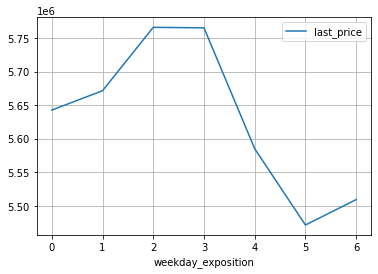

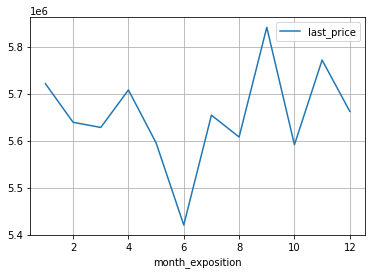

<AxesSubplot:xlabel='year_exposition'>

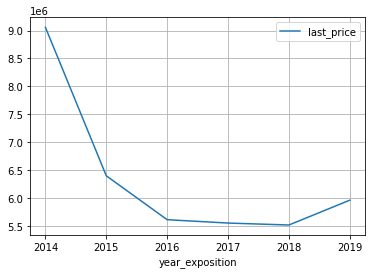

In [73]:
# зависимость между ценой и временем размещения объявления
data.pivot_table(index='weekday_exposition', values='last_price').plot(grid=True)
plt.show()
data.pivot_table(index='month_exposition', values='last_price').plot(grid=True)
plt.show()
data.pivot_table(index='year_exposition', values='last_price').plot(grid=True)

In [74]:
data.pivot_table(index='year_exposition', values='last_price', aggfunc='mean')

,last_price
year_exposition,
2014,9.057874e+06
2015,6.399683e+06
2016,5.613846e+06
2017,5.553727e+06
2018,5.518694e+06
2019,5.963203e+06


На графиках выявили явную зависимость цены от площади квартиры, количеству комнат - при увелечении изучаемого параметра цена увеличивается, что вполне логично и ожидаемо.
Так же можно сказать что цена за квадратный метр квартир на первом этаже существенно меньше, чем для других этажей.
Цена при размещении обьявления в выходные дни ниже чем в будни, но это вполне возможно связано с меньшим количеством обьявлений "дорогих" квартир, т.к. их продают через риэлторов или агентсква недвижимости, которые вероятнее всего размещают объявления в будние дни.
Такая же история для летних месяцев, когда большая часть населения находится в отпусках, сентябрь в этом плане более урожайный месяц, можно сказать что продажа недвижимости имеет небольшую зависимость от сезона.
А вот для года размещения обьявления график получился интересным - явно видно в 2014 году резкое повышение цен на недвижимость, в следсвии валютно-финансового кризиса в нашей стране. В последующие года начался спад цен на недвижимость и только к 2019г постепенный рост.


#### Изучение цены квадратного метра недвижимости в разных населенных пунктах

In [75]:
city_top = data.groupby('locality_name')['one_meter_price'].agg(['count', 'mean'])\
    .sort_values(by = 'count', ascending = False).head(10)

city_top.sort_values(by = 'mean', ascending = False)


,count,mean
locality_name,,
санкт-петербург,14703,109339.847797
пушкин,353,102314.455977
деревня кудрово,263,91932.405551
поселок парголово,308,89916.297532
поселок мурино,522,84919.836054
поселок шушары,421,77827.610380
колпино,335,75295.341075
гатчина,300,68753.189000
всеволожск,383,68613.208825


Самая высокая цена за квадратный метр, в самом Санкт-Петербурге, в г. Пушкин (бывшее Царское село, известное туристическое место, высокая цена на недвижимость вполне оправдана). Деревня Кудрово и Мурино являются ближайшими пригородами Питера, так что в высокая цена на недвижимость тоже вполне оправдана. Поселок Парголово нахоится в выбогском районе, там находится парк с озерами и исторически достопримечательности, согласно Википедии население растет уверенными темпами с 2012 года, делаю вывод что место популярное и востребованное, следовательно высокая цена вполне оправдана. Самая низкая цена за квадратный метр в Выборге, видимо не самое популярное место для покупки квартиры, в следствие чего дешевле цены за квадратный метр.

#### Изучение стоимости квартир в зависимости от расстояния до центра города


Text(0.5, 0, 'Расстояниe от центра города')

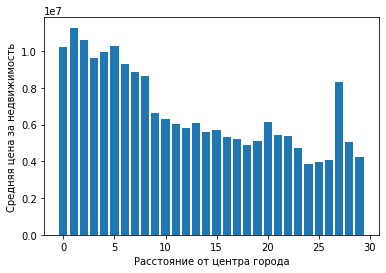

In [84]:
data_citycenter_price = data.query('locality_name=="санкт-петербург"').pivot_table(
    index='citycenters_nearest_km', values='last_price', aggfunc='mean')

data_citycenter_price.columns = ['price_mean']

plt.bar(data_citycenter_price.index, data_citycenter_price['price_mean'])
plt.ylabel("Средняя цена за недвижимость")
plt.xlabel("Расстояниe от центра города")

In [77]:
# изучим аномальный выброс на 27 км
data.loc[(data['citycenters_nearest_km'] ==27)&(
    data['locality_name']=="санкт-петербург")]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year_exposition,one_meter_price,weekday_exposition,month_exposition,floor_type,citycenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,NaN,128.0,2017,193918.92,1,11,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.70,2,16.5,2,False,...,NaN,0.0,NaN,178.0,2018,70312.50,1,2,последний,27.0


    В целом чем ближе к центру тем средняя цена на недвижимость выше, но случаются и выбросы, например, на 27 км выброс случился из за малого количества квартир на этой отметке, цена одной из них сильно выше, что дает большой выброс по среднему значению.

### Напишите общий вывод

**В ходе исследования были проанализированные данные сервиса ЯндексНедвижимость по Санкт-Петербургу. Были обработаны и заполнены по возможности пустые значения в столбцах. А также проанализированы и удалены аномальные значения и выбросы данных по всей выборке.
 Так же в ходе исследования выяснили, что меньше всего квартир продается на первом этаже дома, а больше всего на других этажах. Больше всего продается квартир в 5 и 9 этажках. Выявили зависимости цены от площади квартиры, количеству комнат и этажа. Чем больше комнат и площадь квартиры тем она дороже, также дороже квартиры не на первом и последних этажах.
Проанализировали скорость продажи недвижимости, а также зависимость цены квартиры от даты создания обьявления на продажу.
Лучше всего квартиры продаются в первые два месяца. Начиная с 2019 года рынок недвижимости начал нарастать после кризиса в 2014 году.
    Так же проанализировали цены за квадратный метр в зависимости от населенного пункта и удаления от центра города. Самые дорогие квартиры в центре Санкт-Петербурга и в г. Пушкин.
    Такой анализ можно применять для улучшения сервиса по продаже недвижимости, добавив возможность автоматически проверять при заколнении данные об объекте недвижимости или добавив дополнительные данные**



